# Getting started:

First, you should install the pydub and sounddevice libraries:

In [6]:
# !pip install pydub
# !pip install sounddevice

import pydub
import numpy as np
import sounddevice as sd
import cmath
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
from math import e

class Music: # static class for music I/O standard
    
    @staticmethod
    def plotter(x=None, y=None, title="", xlabel="", ylabel="", figsize=(20, 12), subplt=(1, 1, 1)):
        """
            East plotter
        """
        if x is None:
            x = np.arange(y.shape[0])
        plt.figure(figsize=figsize)
        plt.subplot(subplt)
        plt.plot(x, y)
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        return
    
    @staticmethod
    def frequencies(x, fs):
        """
            Audio vector to frequencies with FFT ratio
        """
        Fd = np.fft.fft(x)
        Fx = np.linspace(0, 1, max(x.shape))*fs
        return Fd, Fx
    
    @staticmethod
    def read_mp3(filename, normalized=False):
        """
            MP3 to numpy array
        """
        a = pydub.AudioSegment.from_mp3(filename)
        y = np.array(a.get_array_of_samples())
        if a.channels == 2:
            y = y.reshape((-1, 2))
        if normalized:
            return a.frame_rate, np.float32(y) / 2**15
        else:
            return a.frame_rate, y
    
    @staticmethod
    def write_mp3(filename, Fs, x, normalized=False):
        """ 
            numpy array to MP3 
        """
        channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
        if normalized:  
            y = np.int16(x * 2 ** 15)
        else:
            y = np.int16(x)
        song = pydub.AudioSegment(y.tobytes(), frame_rate=Fs, sample_width=2, channels=channels)
        song.export(filename, format="mp3", bitrate="320k")
        return

Playing MP3 file:

In [13]:
fs, data = Music.read_mp3('musics/Minuet.mp3') 
sd.play(data[:540000], fs*1.2) # x1.2 speed
sd.wait()
print('Rate = {}, Music data shape = {}'.format(fs, data.shape))

Rate = 44100, Music data shape = (4017152, 2)


Playing wav file:

In [21]:
from scipy.io import wavfile
fs, data = wavfile.read('musics/noisy.wav')
sd.play(data[:10000], fs*0.5) # x0.5 speed
sd.wait()

Recording MP3 file:

In [8]:
fs = 44100  # Sample rate
seconds = 2  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished
Music.write_mp3('musics/myrec.mp3', fs, myrecording, normalized=True)
sd.play(myrecording, fs*1.2) # x1.2 faster
sd.wait()

Making low-pass and band-pass filters:

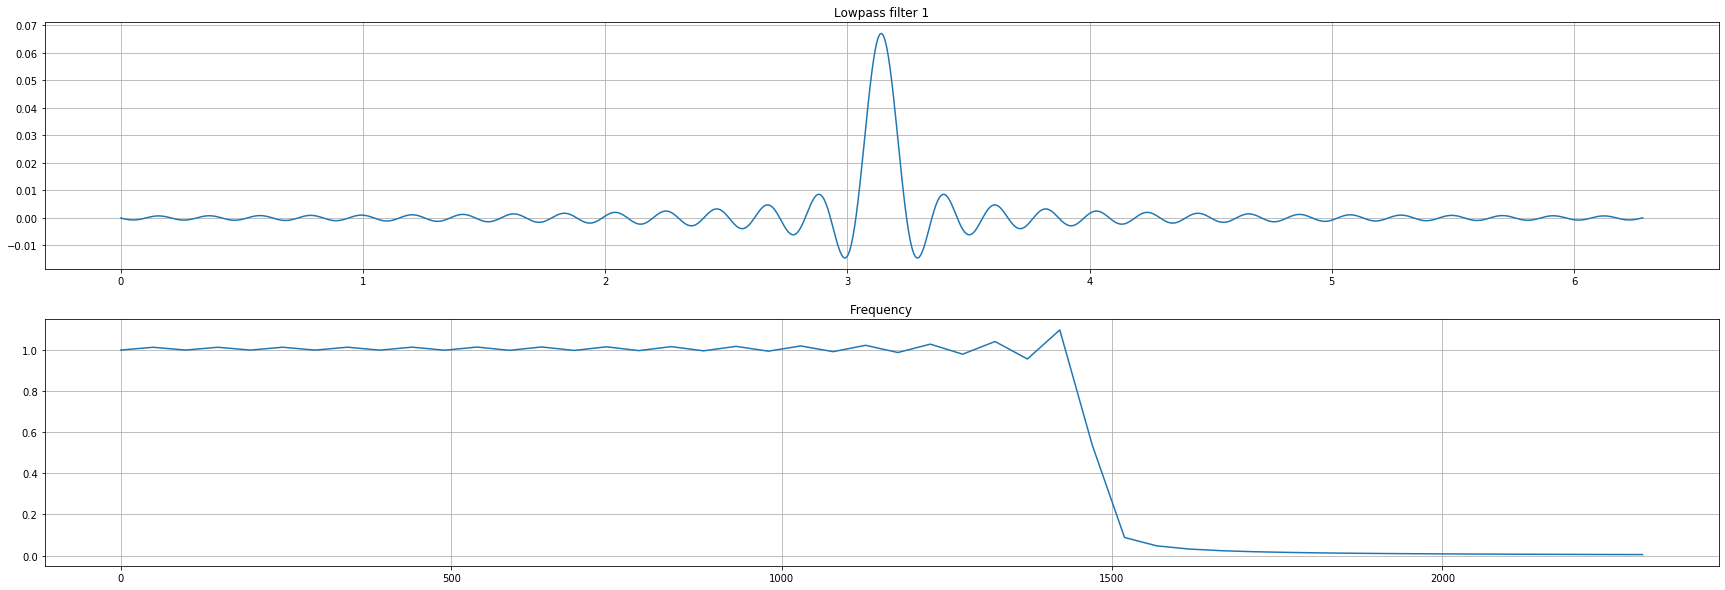

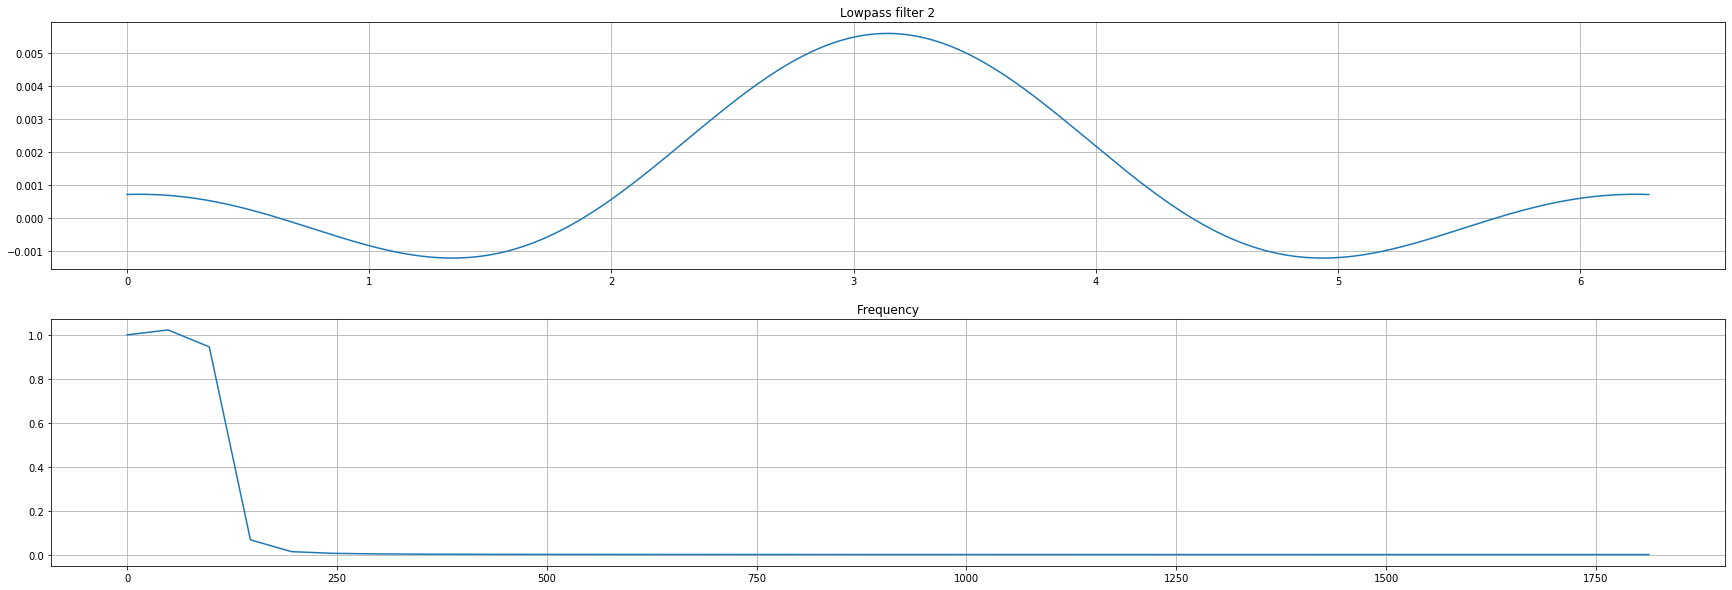

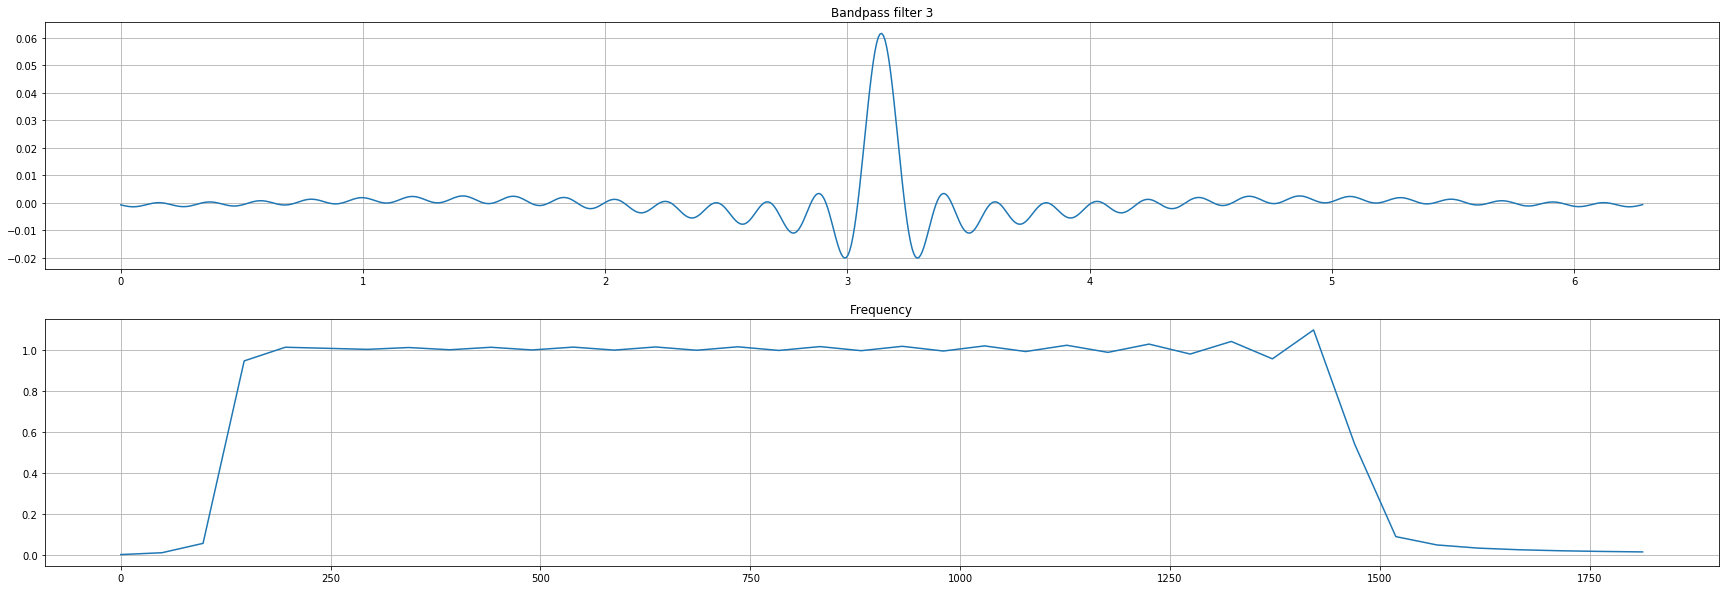

In [9]:
# plotter function
def freqplot(y, fs, N, t1="The signal", t2="Frequency"):

    x = np.linspace(0, 2*np.pi, y.shape[0]) # Zero to 2*pi, one period
    f = np.fft.fft(y)
    p = np.linspace(0, fs, y.shape[0])

    plt.figure(figsize=(30, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(x, y)
    plt.grid(True)
    plt.title(t1)
    
    plt.subplot(2, 1, 2)
    plt.plot(p[:N], np.abs(f[:N]))
    plt.grid(True)
    plt.title(t2)
    plt.show()
    

x = np.linspace(-7.85*12, 7.86*12, 901)
lfilter1 = np.sin(x)/x
nm = np.sum(lfilter1)
lfilter1 /= nm

x = np.linspace(-7.85, 7.86, 901)
lfilter2 = np.sin(x)/x
nm = np.sum(lfilter2)
lfilter2 /= nm

lfilter3 = lfilter1-lfilter2

freqplot(lfilter1, fs1, 48, "Lowpass filter 1")
freqplot(lfilter2, fs1, 38, "Lowpass filter 2")
freqplot(lfilter3, fs1, 38, "Bandpass filter 3")

Applying filters:

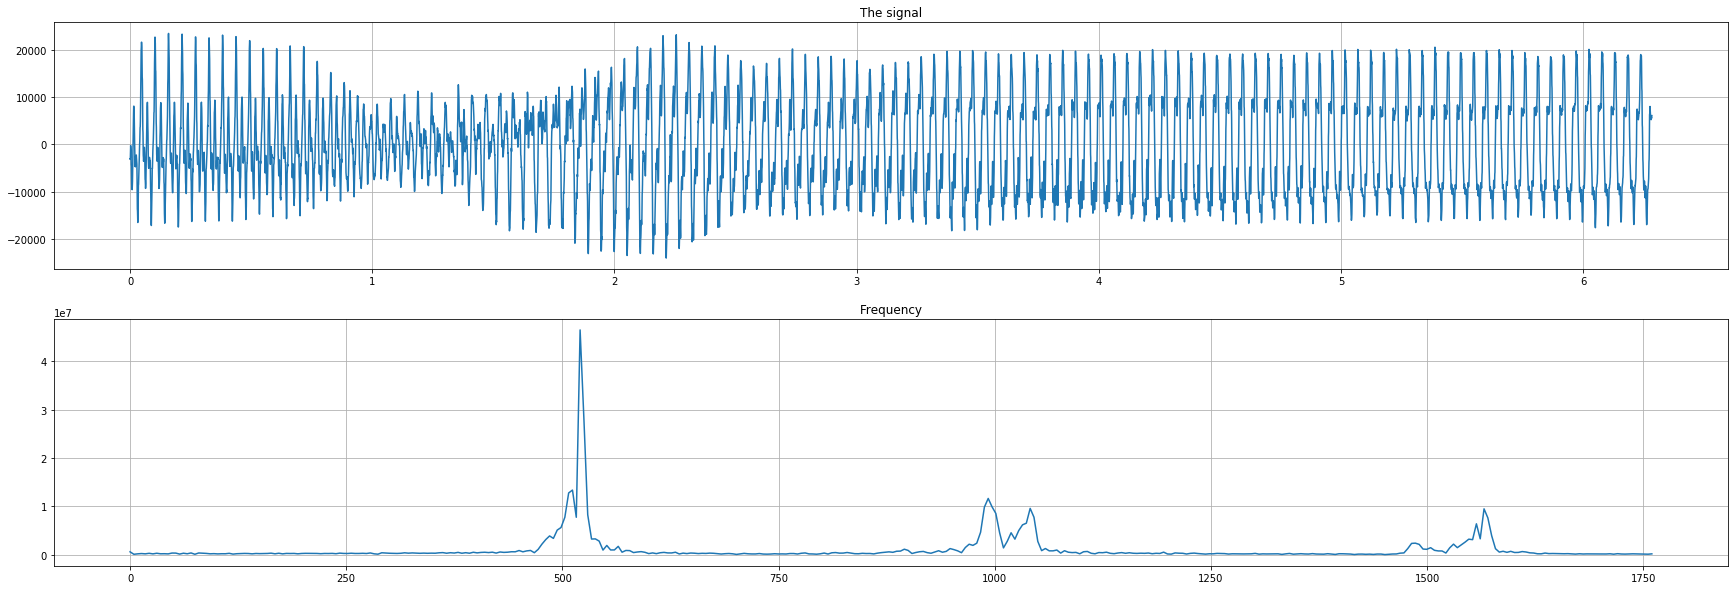

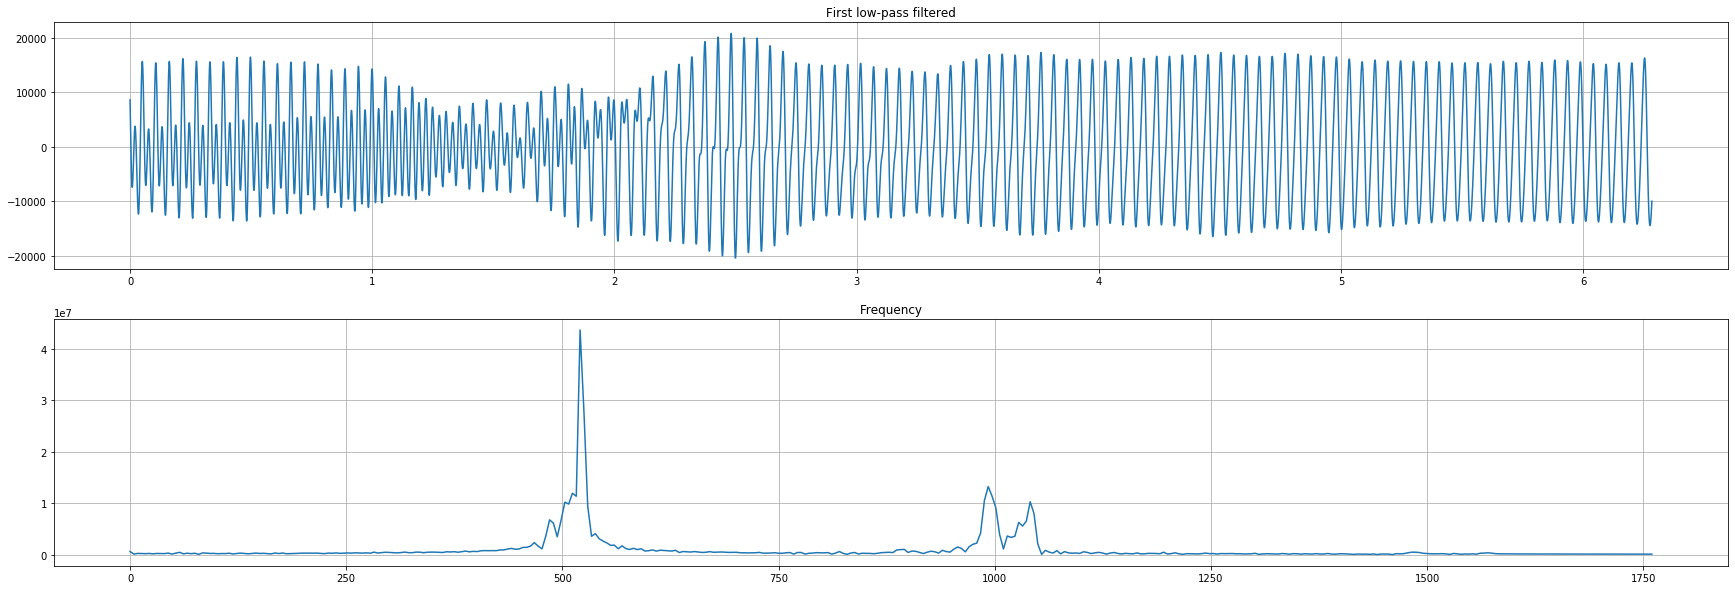

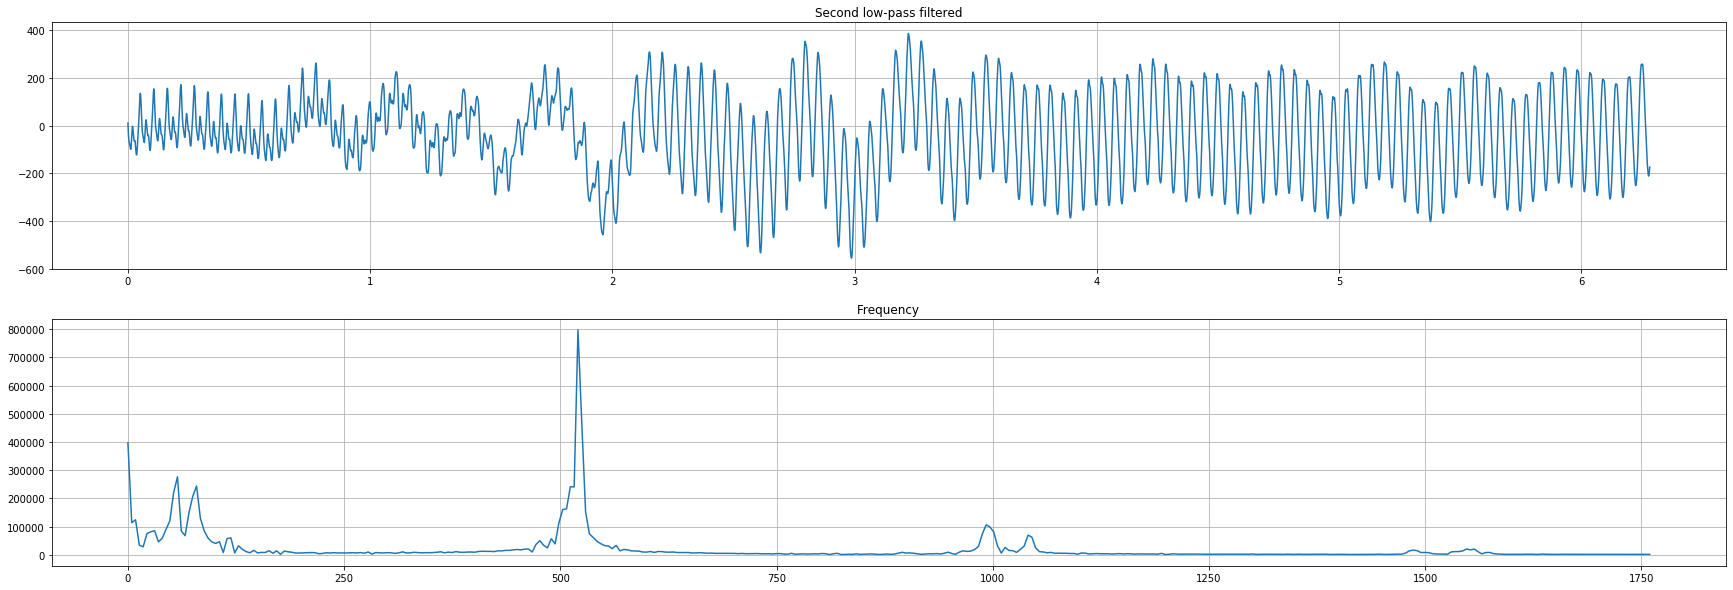

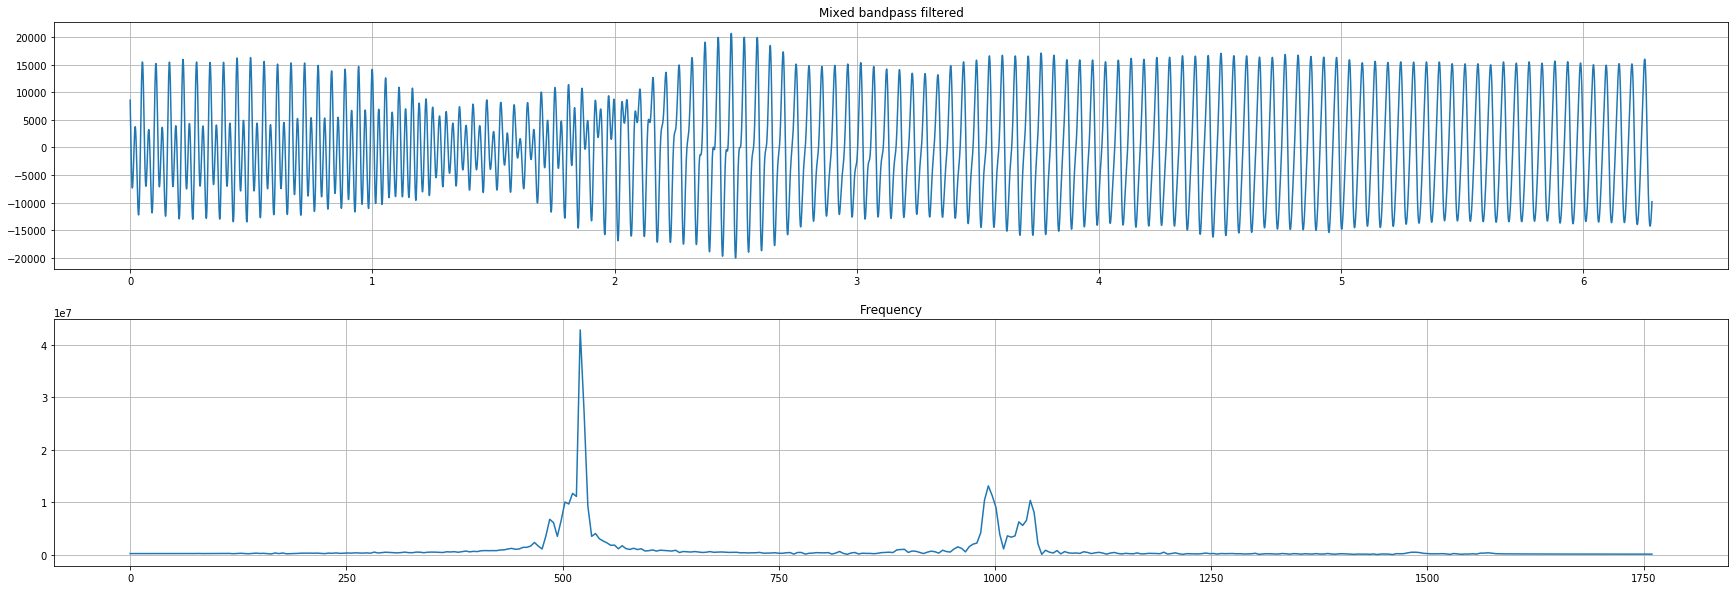

In [10]:
fs = 44100  # Sample rate
fs1, data1 = Music.read_mp3('musics/Minuet.mp3')

d1 = np.convolve(data1[:, 1], lfilter1)
d2 = np.convolve(data1[:, 1], lfilter2)

y = data1[75000:85000, 1]
y1 = d1[75000:85000]
y2 = d2[75000:85000]

freqplot(y, fs, 400)
freqplot(y1, fs, 400, "First low-pass filtered")
freqplot(y2, fs, 400, "Second low-pass filtered")
freqplot(y1 - y2, fs, 400, "Mixed bandpass filtered")

Butterworth filter:

/Users/sarvin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


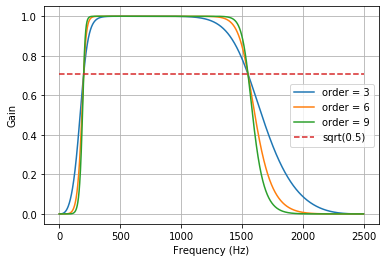

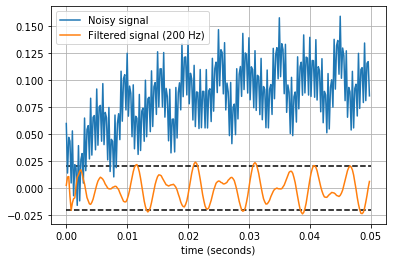

In [4]:
from scipy.signal import butter, lfilter, freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 200.0
    highcut = 1550.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 200.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()


run()

More information at: https://en.wikipedia.org/wiki/Butterworth_filter